In [67]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
import scipy
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
import sqlalchemy, pymysql
db = sqlalchemy.create_engine(
     sqlalchemy.engine.url.URL(
          drivername="mysql+pymysql",
          username="root",
          password="intense-agency-314911", 
          host="34.101.233.26", 
          database="db_raw"
     )
)

In [7]:
df = []
with db.connect() as conn:
     qry = "SELECT * FROM details"
     results = conn.execute(qry).fetchall()
     for row in results:
            df.append(row)
Order_db = []
with db.connect() as conn:
    query = "SELECT Order_ID, Order_Date FROM orderr;"
    results = conn.execute(query).fetchall()
    for row in results:
        Order_db.append(row)

In [80]:


print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

Tensorflow Version: 2.3.0
Pandas Version: 0.25.1
Numpy Version: 1.16.5
System Version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


In [118]:
data_product = pd.DataFrame.from_records(df, columns = ["Order_ID", "Size", "Color", "Order", "Detail_Divan"])
data_order = pd.DataFrame.from_records(Order_db, columns = ["Order_ID", "Order_Date"])
data_product["Detail_Divan"] = data_product["Detail_Divan"].str.replace(r'\r', "")
data_order["Order_Date"] = pd.to_datetime(data_order["Order_Date"])
joined = data_product.set_index("Order_ID").join(data_order.set_index("Order_ID")).reset_index()

In [124]:
joined_week = joined.copy()
joined_week["Order_Date"] = joined.Order_Date.dt.to_period('W').dt.to_timestamp()
week_agg = joined_week.groupby(["Order_Date", "Order"]).size().unstack("Order")
week_agg = week_agg.fillna(0)

In [125]:
week_agg.describe()

Order,Tipe1,Tipe2,Tipe3,Tipe4
count,105.000000,105.000000,105.000000,105.000000
mean,22.247619,13.542857,12.057143,9.295238
std,7.362562,5.832648,5.094923,4.787652
min,4.000000,0.000000,0.000000,0.000000
25%,18.000000,10.000000,8.000000,6.000000
50%,22.000000,14.000000,12.000000,10.000000
75%,26.000000,16.000000,14.000000,14.000000
max,42.000000,30.000000,30.000000,22.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACC06290C8>,
      dtype=object)

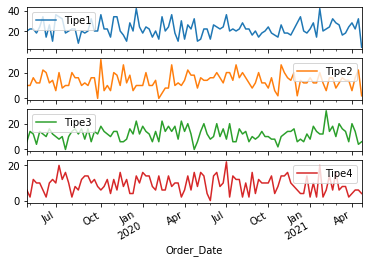

In [126]:
week_agg.plot(subplots = True)

#This is for the 4 input 1 output

In [127]:
week_train = week_agg[:84]
week_test = week_agg[84:]
week_train


Order,Tipe1,Tipe2,Tipe3,Tipe4
Order_Date,,,,
2019-04-29,20.0,10.0,6.0,6.0
2019-05-06,22.0,10.0,14.0,2.0
2019-05-13,22.0,16.0,12.0,12.0
2019-05-20,18.0,12.0,4.0,10.0
2019-05-27,24.0,12.0,14.0,10.0
...,...,...,...,...
2020-11-02,26.0,26.0,10.0,14.0
2020-11-09,18.0,20.0,12.0,14.0
2020-11-16,18.0,16.0,14.0,16.0


In [128]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(week_train)

Order       Tipe1  Tipe2  Tipe3  Tipe4
Order_Date                            
2019-04-29   20.0   10.0    6.0    6.0
2019-05-06   22.0   10.0   14.0    2.0
2019-05-13   22.0   16.0   12.0   12.0
2019-05-20   18.0   12.0    4.0   10.0
2019-05-27   24.0   12.0   14.0   10.0
2019-06-03   34.0   22.0   12.0    6.0
2019-06-10   14.0   20.0   10.0    2.0
2019-06-17   26.0   12.0   16.0   10.0
2019-06-24   10.0   14.0   12.0   12.0
2019-07-01   36.0    6.0   10.0   10.0
2019-07-08   34.0   20.0    8.0   20.0
2019-07-15   32.0    8.0   10.0   12.0
2019-07-22   18.0   10.0    0.0   16.0
2019-07-29   20.0   10.0   10.0   10.0
2019-08-05   22.0   20.0   14.0    2.0
2019-08-12   22.0   16.0   16.0    8.0
2019-08-19    8.0   16.0   12.0    6.0
2019-08-26   20.0   10.0   16.0   12.0
2019-09-02   18.0   12.0    8.0   14.0
2019-09-09   20.0   10.0   16.0   14.0
2019-09-16   32.0   16.0    6.0   10.0
2019-09-23   20.0   16.0   14.0   12.0
2019-09-30   20.0    0.0   12.0    8.0
2019-10-07   36.0   30.0 

In [129]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(week_train)
df_for_train = scaler.transform(week_train)
df_for_test = scaler.transform(week_test)



In [130]:
trainX = []
trainY = []
n_future = 1
n_past = 4

for i in range(n_past, len(df_for_train) - n_future +1):
    trainX.append(df_for_train[i - n_past:i, 0:df_for_train.shape[1]])
    trainY.append(df_for_train[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (80, 4, 4).
trainY shape == (80, 1).


In [131]:
testX = []
testY = []
for i in range(n_past, len(df_for_test) - n_future +1):
    testX.append(df_for_test[i - n_past:i, 0:df_for_test.shape[1]])
    testY.append(df_for_test[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('trainX shape == {}.'.format(testX.shape))
print('trainY shape == {}.'.format(testY.shape))

trainX shape == (17, 4, 4).
trainY shape == (17, 1).


In [134]:
    from tensorflow.keras import optimizers

model = tf.keras.Sequential()
model.add(GRU(32, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(GRU(16, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

optimizer = optimizers.Adam(clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 4, 32)             3648      
_________________________________________________________________
gru_11 (GRU)                 (None, 16)                2400      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 6,065
Trainable params: 6,065
Non-trainable params: 0
_________________________________________________________________


In [135]:
history = model.fit(trainX, trainY, epochs=50, batch_size=1, validation_data=(testX, testY), verbose=1)


Epoch 1/50
80/80 [==============================] - 1s 10ms/step - loss: 1.0728 - val_loss: 1.3359
Epoch 2/50
80/80 [==============================] - 0s 4ms/step - loss: 1.0659 - val_loss: 1.3528
Epoch 3/50
80/80 [==============================] - 0s 5ms/step - loss: 1.0198 - val_loss: 1.3290
Epoch 4/50
80/80 [==============================] - 0s 5ms/step - loss: 1.0264 - val_loss: 1.2986
Epoch 5/50
80/80 [==============================] - 0s 5ms/step - loss: 1.0282 - val_loss: 1.2546
Epoch 6/50
80/80 [==============================] - 0s 5ms/step - loss: 0.9987 - val_loss: 1.2491
Epoch 7/50
80/80 [==============================] - 0s 4ms/step - loss: 1.0094 - val_loss: 1.2311
Epoch 8/50
80/80 [==============================] - 0s 6ms/step - loss: 0.9746 - val_loss: 1.2378
Epoch 9/50
80/80 [==============================] - 0s 5ms/step - loss: 0.9896 - val_loss: 1.2179
Epoch 10/50
80/80 [==============================] - 0s 4ms/step - loss: 0.9681 - val_loss: 1.2425
Epoch 11/50
80/80 

#This for the 4 input 4 output

In [137]:
train_df,test_df = week_agg[:85], week_agg[85:]

In [138]:
from sklearn.preprocessing import MinMaxScaler
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

ipykernel_launcher:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:9: SettingWithCopyWarning: 
A value is trying to be se

In [139]:
def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 4
n_future = 1 
n_features = 4

In [140]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [141]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e1d1.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 4, 4)]       0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 100), (None, 42000       input_3[0][0]                    
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 1, 100)       0           lstm_8[0][0]                     
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 1, 100)       80400       repeat_vector_2[0][0]            
                                                                 lstm_8[0][1]          

In [143]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

Epoch 1/25
3/3 [==============================] - 1s 368ms/step - loss: 0.0964 - val_loss: 0.1319
Epoch 2/25
3/3 [==============================] - 0s 15ms/step - loss: 0.0940 - val_loss: 0.1294
Epoch 3/25
3/3 [==============================] - 0s 16ms/step - loss: 0.0920 - val_loss: 0.1285
Epoch 4/25
3/3 [==============================] - 0s 16ms/step - loss: 0.0906 - val_loss: 0.1278
Epoch 5/25
3/3 [==============================] - 0s 15ms/step - loss: 0.0897 - val_loss: 0.1276
Epoch 6/25
3/3 [==============================] - 0s 14ms/step - loss: 0.0890 - val_loss: 0.1276
Epoch 7/25
3/3 [==============================] - 0s 21ms/step - loss: 0.0884 - val_loss: 0.1276
Epoch 8/25
3/3 [==============================] - 0s 15ms/step - loss: 0.0880 - val_loss: 0.1278
Epoch 9/25
3/3 [==============================] - 0s 15ms/step - loss: 0.0877 - val_loss: 0.1280
Epoch 10/25
3/3 [==============================] - 0s 17ms/step - loss: 0.0875 - val_loss: 0.1282
Epoch 11/25
3/3 [===========

#Thanks to JAGADEESH23 for some of the code